# 청경채 잎 면적 증감률 예측

In [66]:
# 모듈 로딩
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

# copy 경고 무시
pd.set_option('mode.chained_assignment',  None)

In [38]:
# 데이터 경로
path_input='./data/train_input/'
path_target='./data/train_target/'

In [39]:
# 함수 만들기


# input 데이터 전처리
def input_data(file):
    
    path_input='./data/train_input/'
    
    # 파일 불러오기
    df=pd.read_csv(path_input+file)
    
    
    # 컬럼명 변경
    df.columns=['시간', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치',
       '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량', '냉방상태', '냉방작동남은시간', '난방상태',
       '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간',
       '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태', '레드 LED작동남은시간',
       '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도', '카메라상태', '냉방온도',
       '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량',
       '청색광추정광량']
    
    # 필요한 컬럼만 남기기
    df1=df[['시간', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치',
        '일간누적분무량', '백색광추정광량', '적색광추정광량', '청색광추정광량']]

    # 결측치 제거
    df1=df1.dropna()
    
    return df1

# 데이터 일별 그룹화 후 평균
def group_data(df):
    
    # 월,일만 남긴 후 일별로 그룹화
    df['시간']=df['시간'].apply(lambda x : x[0:10])
    df=df.groupby('시간')
    
    # 일별 최종 분무량
    df_max=df['일간누적분무량'].max()
    
    # 일별 평균 및 누적분무량
    df_mean=df.mean()
    df_mean['일간누적분무량']=df_max
    df_mean['DAY']=df.groups
    
    return df_mean

# target 데이터 전처리
def target_data():
    path_target='./data/train_target/'

    target_file=os.listdir(path_target)
    target=pd.DataFrame()
    
    for i in target_file:
        df=pd.read_csv(path_target+i)
        df['시간']=pd.to_datetime(df['시간'])+datetime.timedelta(days=-1)
        df['시간']=df['시간'].astype('object')
        df['시간']=df['시간'].apply(lambda x : str(x)[0:10])
        target=pd.concat([target, df], ignore_index=True)
    target.columns=['DAY','rate']
    
    return target

In [40]:
# data 생성

input_file=os.listdir(path_input)

data=pd.DataFrame()

for i in input_file:
    df=input_data(i)
    data=pd.concat([data, group_data(df)], ignore_index=True)

In [41]:
# target 생성

target_data=target_data()
rate_list=[]
for i in data['DAY']:
    for j in target_data['DAY']:
        if i==j:
            rate=target_data[target_data['DAY']==i]['rate']
            rate=rate.values.astype(np.float)[0]
            rate_list.append(rate)
            break

In [42]:
# 배열로 
data=np.array(data.iloc[:,:-1])
target=np.array(rate_list)

In [43]:
# 훈련 데이터셋과 테스트 데이터셋 나누기
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [47]:
# all_estimators 최적 모델

from sklearn.utils import all_estimators
models = all_estimators(type_filter='regressor')

# 경고무시
import warnings
warnings.filterwarnings('ignore')

s_n=[]

# QuantileRegressor 제외
for name, model in models[:41]+models[43:]:
    
    # error 발생시 pass
    try:
        
        # 모델 객체 생성
        md=model()
        # print(name)
        # 학습
        md.fit(x_train, y_train)
        # 평가
        score=md.score(x_train, y_train)
                
        # 이름과 점수 리스트에 담기
        s_n.append((name, score)) # 이름과 점수 한번에 담기
        
    except:
        pass
    
s_n.sort(reverse=True,key= lambda x: x[1])
s_n

[('DecisionTreeRegressor', 1.0),
 ('ExtraTreeRegressor', 1.0),
 ('ExtraTreesRegressor', 1.0),
 ('GaussianProcessRegressor', 1.0),
 ('RadiusNeighborsRegressor', 0.9999949215029675),
 ('GradientBoostingRegressor', 0.9459421958151728),
 ('AdaBoostRegressor', 0.8047247070688949),
 ('RandomForestRegressor', 0.7924411011136521),
 ('BaggingRegressor', 0.7587934225435486),
 ('HistGradientBoostingRegressor', 0.6969217798988689),
 ('KNeighborsRegressor', 0.21237602835678016),
 ('Lars', 0.0032179229126565456),
 ('LinearRegression', 0.0032179229126565456),
 ('TransformedTargetRegressor', 0.0032179229126565456),
 ('RidgeCV', 0.0032179228924460457),
 ('Ridge', 0.0032179228870981014),
 ('PLSRegression', 0.003203793313707348),
 ('OrthogonalMatchingPursuit', 0.0025180460123791493),
 ('OrthogonalMatchingPursuitCV', 0.0025180460123791493),
 ('KernelRidge', 0.002320516334337497),
 ('ARDRegression', 0.0023051040818169444),
 ('LassoLarsIC', 0.00217717006038598),
 ('TweedieRegressor', 0.0011869541050093524),

In [ ]:
# DecisionTreeRegressor, ExtraTreeRegressor, GradientBoostingRegressor, RandomForestRegressor
# RadiusNeighborsRegressor, BaggingRegressor, HistGradientBoostingRegressor

In [63]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree=DecisionTreeRegressor(random_state=0).fit(x_train, y_train)

print("훈  련 세트 점수:", tree.score(x_train, y_train))
print("테스트 세트 점수:", tree.score(x_test, y_test))

훈  련 세트 점수: 1.0
테스트 세트 점수: -0.24122344680549745


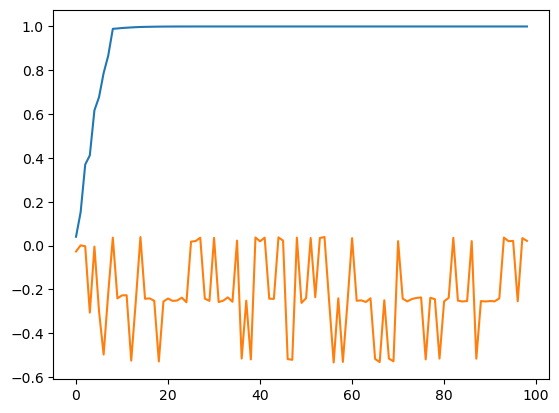

In [67]:
# max_depth 파라미터
from sklearn.tree import DecisionTreeRegressor
x_=[]
y_=[]
for i in range(1,100):
    tree=DecisionTreeRegressor(max_depth=i).fit(x_train, y_train)
    x_.append(tree.score(x_train, y_train))
    y_.append(tree.score(x_test, y_test))
    # print("훈  련 세트 점수:", tree.score(x_train, y_train))
    # print("테스트 세트 점수:", tree.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)

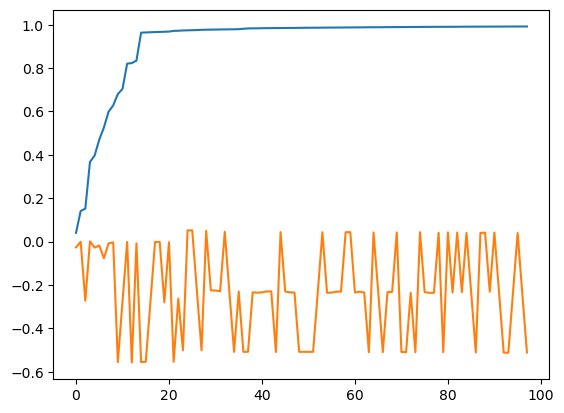

In [73]:
# max_leaf_nodes 파라미터
x_=[]
y_=[]
for i in range(2,100):
    tree=DecisionTreeRegressor(max_leaf_nodes=i).fit(x_train, y_train)
    x_.append(tree.score(x_train, y_train))
    y_.append(tree.score(x_test, y_test))
    # print("훈  련 세트 점수:", tree.score(x_train, y_train))
    # print("테스트 세트 점수:", tree.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)

In [69]:
# ExtraTreeRegressor
from sklearn.tree import ExtraTreeRegressor

tree=ExtraTreeRegressor(random_state=0).fit(x_train, y_train)

print("훈  련 세트 점수:", tree.score(x_train, y_train))
print("테스트 세트 점수:", tree.score(x_test, y_test))

훈  련 세트 점수: 1.0
테스트 세트 점수: -1.5419625177370948


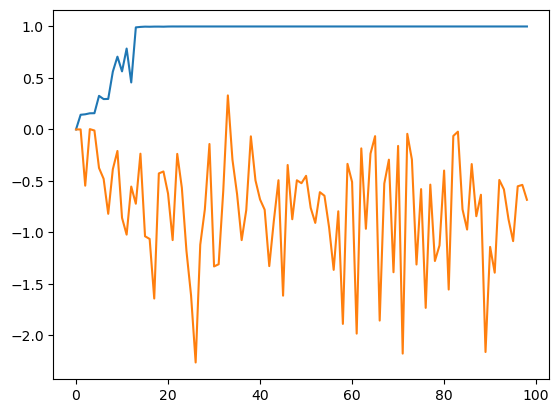

In [70]:
# max_depth
from sklearn.tree import ExtraTreeRegressor
x_=[]
y_=[]
for i in range(1,100):
    tree=ExtraTreeRegressor(max_depth=i).fit(x_train, y_train)
    x_.append(tree.score(x_train, y_train))
    y_.append(tree.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)
plt.show()

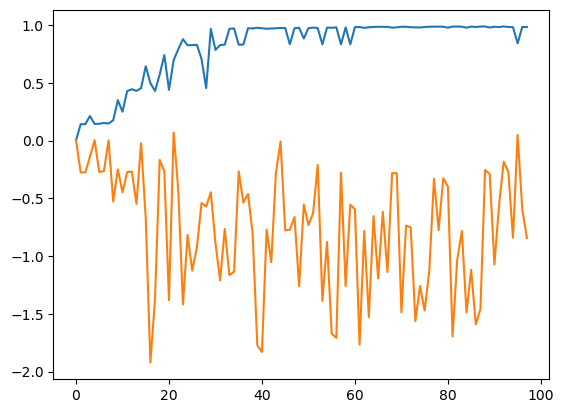

In [72]:
# max_leaf_nodes
from sklearn.tree import ExtraTreeRegressor
x_=[]
y_=[]
for i in range(2,100):
    tree=ExtraTreeRegressor(max_leaf_nodes=i).fit(x_train, y_train)
    x_.append(tree.score(x_train, y_train))
    y_.append(tree.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)
plt.show()

In [74]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

rfr=RandomForestRegressor(random_state=0).fit(x_train, y_train)

print("훈  련 세트 점수:", rfr.score(x_train, y_train))
print("테스트 세트 점수:", rfr.score(x_test, y_test))

훈  련 세트 점수: 0.8067849544423322
테스트 세트 점수: -0.02424058807113716


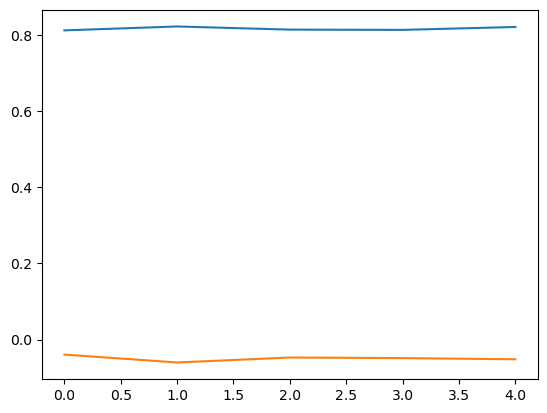

In [76]:
# n_estimators

x_=[]
y_=[]
for i in range(100, 501, 100):
    rfr=RandomForestRegressor(n_estimators=i).fit(x_train, y_train)
    x_.append(rfr.score(x_train, y_train))
    y_.append(rfr.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)
plt.show()

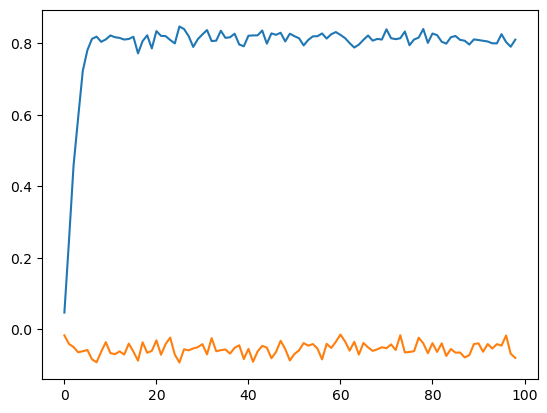

In [75]:
# max_depth
x_=[]
y_=[]
for i in range(1,100):
    rfr=RandomForestRegressor(max_depth=i).fit(x_train, y_train)
    x_.append(rfr.score(x_train, y_train))
    y_.append(rfr.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)
plt.show()

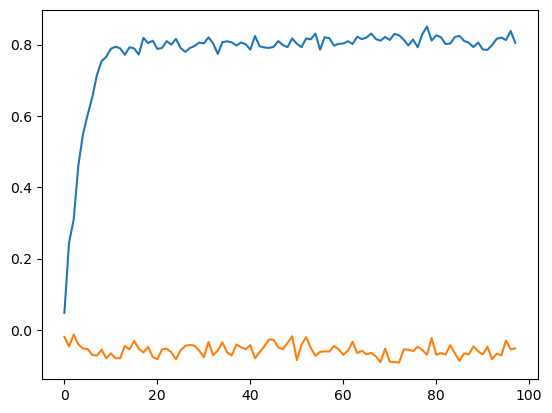

In [80]:
# max_leaf_nodes
x_=[]
y_=[]
for i in range(2,100):
    rfr=RandomForestRegressor(max_leaf_nodes=i).fit(x_train, y_train)
    x_.append(rfr.score(x_train, y_train))
    y_.append(rfr.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)
plt.show()

In [81]:
# XGB
import xgboost as xgb

md=xgb.XGBRegressor().fit(x_train, y_train)

print("훈  련 세트 점수:", rfr.score(x_train, y_train))
print("테스트 세트 점수:", rfr.score(x_test, y_test))

훈  련 세트 점수: 0.8048645336133837
테스트 세트 점수: -0.05194452839960095


In [82]:
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gbr=GradientBoostingRegressor().fit(x_train, y_train)
print("훈  련 세트 점수:", gbr.score(x_train, y_train))
print("테스트 세트 점수:", gbr.score(x_test, y_test))

훈  련 세트 점수: 0.9459421958151728
테스트 세트 점수: -0.1581813164844359


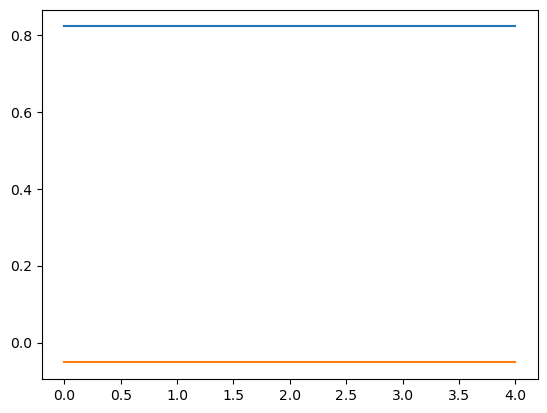

In [83]:
# n_estimators

x_=[]
y_=[]
for i in range(100, 501, 100):
    gbr=GradientBoostingRegressor(n_estimators=i).fit(x_train, y_train)
    x_.append(tree.score(x_train, y_train))
    y_.append(tree.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)
plt.show()

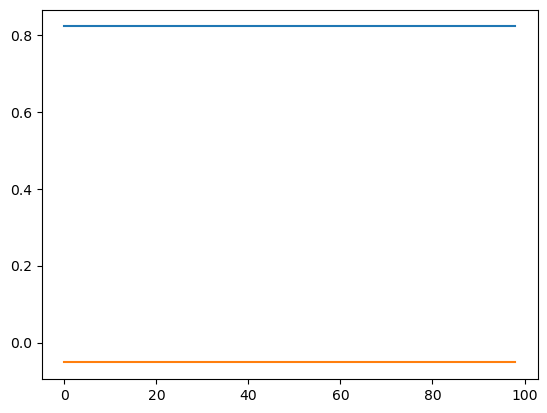

In [84]:
# learning_rate

x_=[]
y_=[]
for i in np.arange(0.01,1,0.01):
    gbr=GradientBoostingRegressor(learning_rate=i).fit(x_train, y_train)
    x_.append(tree.score(x_train, y_train))
    y_.append(tree.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)
plt.show()

In [85]:
# HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
hgb=HistGradientBoostingRegressor().fit(x_train, y_train)
print("훈  련 세트 점수:", hgb.score(x_train, y_train))
print("테스트 세트 점수:", hgb.score(x_test, y_test))

훈  련 세트 점수: 0.6969217798988689
테스트 세트 점수: -0.03519223821575368


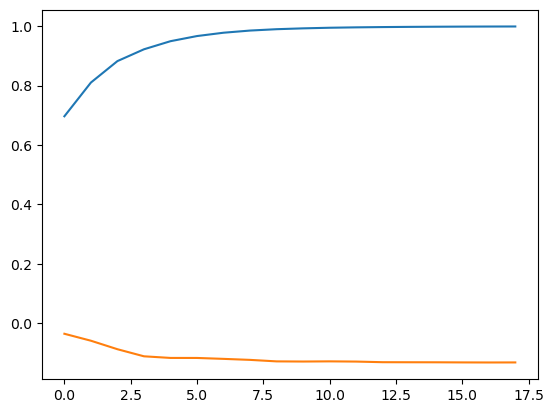

In [86]:
# max_iter
x_=[]
y_=[]
for i in range(100, 1000, 50):
    gbr=HistGradientBoostingRegressor(max_iter=i).fit(x_train, y_train)
    x_.append(gbr.score(x_train, y_train))
    y_.append(gbr.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)
plt.show()

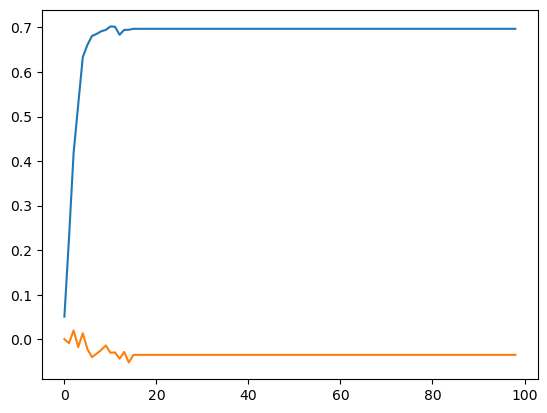

In [87]:
# max_depth
x_=[]
y_=[]
for i in range(1, 100):
    gbr=HistGradientBoostingRegressor(max_depth=i).fit(x_train, y_train)
    x_.append(gbr.score(x_train, y_train))
    y_.append(gbr.score(x_test, y_test))
plt.plot(x_)
plt.plot(y_)
plt.show()

In [ ]:
# 스케일링

# # StandardScaler()
# from sklearn.preprocessing import StandardScaler

# std = StandardScaler()
# std.fit(x_train)
# X_train_scaled = std.transform(x_train)
# X_test_scaled = std.transform(x_test)
# dtc.fit(X_train_scaled, y_train)
# print('모델의 정확도 :', round(dtc.score(X_test_scaled, y_test), 4))



# # MinMaxScaler()
# from sklearn.preprocessing import MinMaxScaler

# mms = MinMaxScaler()
# mms.fit(x_train)
# X_train_scaled = mms.transform(x_train)
# X_test_scaled = mms.transform(x_test)
# dtc.fit(X_train_scaled, y_train)
# print('모델의 정확도 :', round(dtc.score(X_test_scaled, y_test), 4))



# # MaxAbsScaler()
# from sklearn.preprocessing import MaxAbsScaler

# mas = MaxAbsScaler()
# mas.fit(x_train)
# X_train_scaled = mas.transform(x_train)
# X_test_scaled = mas.transform(x_test)
# dtc.fit(X_train_scaled, y_train)
# print('모델의 정확도 :', round(dtc.score(X_test_scaled, y_test), 4))


# # RobustScaler()
# from sklearn.preprocessing import RobustScaler

# rbs = RobustScaler()
# X_train_scaled = rbs.fit_transform(x_train)
# X_test_scaled = rbs.transform(x_test)
# dtc.fit(x_train_scaled, y_train)
# print('모델의 정확도 :', round(dtc.score(X_test_scaled, y_test), 4))


# # Normalizer()
# from sklearn.preprocessing import Normalizer

# norm = Normalizer()
# X_train_scaled = norm.fit_transform(x_train)
# X_test_scaled = norm.transform(x_test)
# dtc.fit(X_train_scaled, y_train)
# print('모델의 정확도 :', round(dtc.score(X_test_scaled, y_test), 4))

In [88]:
# RMSE
from sklearn.metrics import mean_squared_error

# RMSE = (mean_squared_error(y_test, model.predict(x_test))**0.5)*100

In [91]:
# 경고무시
import warnings
warnings.filterwarnings('ignore')

n_R=[]

for name, model in models[:41]+models[43:]:
    
    # error 발생시 pass
    try:
        
        # 모델 객체 생성
        md=model()

        # 학습
        md.fit(x_train, y_train)
        # 평가

        RMSE = (mean_squared_error(y_test, md.predict(x_test))**0.5)*100
        
        # 이름과 점수 리스트에 담기

        n_R.append((name, RMSE)) # 이름과 점수 한번에 담기
        
    except:
        pass

n_R.sort(key= lambda x: x[1])
n_R

[('AdaBoostRegressor', 144.40965946414798),
 ('LassoLarsIC', 147.25672409143064),
 ('ARDRegression', 147.26103319251354),
 ('LarsCV', 147.26504745023738),
 ('LassoLarsCV', 147.26504745023738),
 ('ElasticNetCV', 147.2704552860688),
 ('LassoCV', 147.27045528608278),
 ('DummyRegressor', 147.270565217304),
 ('LassoLars', 147.270565217304),
 ('Lasso', 147.27057209903973),
 ('BayesianRidge', 147.27079242704008),
 ('ElasticNet', 147.27228349284388),
 ('OrthogonalMatchingPursuit', 147.28900989291415),
 ('OrthogonalMatchingPursuitCV', 147.28900989291415),
 ('KernelRidge', 147.37421104969147),
 ('TweedieRegressor', 147.3797393732565),
 ('Ridge', 147.41728469643616),
 ('RidgeCV', 147.41730289243068),
 ('Lars', 147.4173037109227),
 ('LinearRegression', 147.4173037109227),
 ('TransformedTargetRegressor', 147.4173037109227),
 ('PLSRegression', 147.41751117218047),
 ('NuSVR', 147.54374954977908),
 ('SVR', 147.5704077388967),
 ('HuberRegressor', 147.5979958244323),
 ('TheilSenRegressor', 147.690129048

In [1]:
# 그리드 서치 lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

md = Lasso(random_state=0)

best_score=0

param_gird={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid_search=GridSearchCV(md, param_grid=param_gird, scoring='accuracy',cv=5, n_jobs=-1)

grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

NameError: name 'x_train' is not defined

In [98]:
# Lasso

md = Lasso(random_state=0, alpha=0.0001).fit(x_train, y_train)

RMSE = (mean_squared_error(y_train, md.predict(x_train))**0.5)*100
RMSE2 = (mean_squared_error(y_test, md.predict(x_test))**0.5)*100

print("훈  련 세트 RMSE:", RMSE)
print("테스트 세트 RMSE:", RMSE2)

훈  련 세트 RMSE: 118.28133345118755
테스트 세트 RMSE: 147.41716936275205


In [96]:
# ARDRegression

from sklearn.linear_model import ARDRegression

md = ARDRegression().fit(x_train, y_train)

RMSE = (mean_squared_error(y_train, md.predict(x_train))**0.5)*100
RMSE2 = (mean_squared_error(y_test, md.predict(x_test))**0.5)*100

print("훈  련 세트 RMSE:", RMSE)
print("테스트 세트 RMSE:", RMSE2)

훈  련 세트 RMSE: 118.33547991544602
테스트 세트 RMSE: 147.26103319251354
